In [1]:
import pickle
from Agent_DDH_Class import Agent_DDH
from Agent_Class import Agent_Straddles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import norm
import warnings


with open('DataSet/call_list.pkl', 'rb') as f:
    call_list = pickle.load(f)
with open('DataSet/put_list.pkl', 'rb') as f:
    put_list = pickle.load(f)
with open('DataSet/dates.pkl', 'rb') as f:
    trade_dates = pickle.load(f)
with open('DataSet/date_strs.pkl', 'rb') as f:
    trade_dates_str = pickle.load(f)


In [2]:
underlying_df = pd.read_csv('DataSet/underlying.csv', parse_dates=['Date'])
date_list = underlying_df['Date'].dt.strftime('%Y-%m-%d').tolist()
n_days = len(date_list)

close_prices = underlying_df['Close'].values
underlying_returns = np.diff(close_prices) / close_prices[:-1]
underlying_returns = np.insert(underlying_returns, 0, 0.0)  # align length
cum_underlying = np.cumprod(1 + underlying_returns) - 1

## Initialize Agents

In [ ]:
agent_ddh = Agent_DDH(
    balance=10000.0,
    vega_risk_frac=0.9,
    vrp_z_threshold=0.5,
    tx_cost=0.005,
    rehedge_freq=1,
    stop_loss_frac=0.15,
    min_ttm=1/252,
    max_ttm=30/252
)

agent_straddle = Agent_Straddles(
    balance=10000.0,
    sizing_method='vega',
    vega_risk_frac=0.9,
    vrp_z_threshold=0.5,
    tx_cost=0.005,
    stop_loss_frac=0.20,
    min_ttm=1/252,
    max_ttm=30/252
)

## Start Back_test

In [ ]:


# ==========================
# Initialize result storage
# ==========================
def init_arrays(n):
    return (
        [np.nan] * n,  # nav
        [np.nan] * n,  # gamma
        [np.nan] * n,  # delta
        [np.nan] * n,  # vega
        [np.nan] * n,  # theta
        [np.nan] * n,  # num_options
        [np.nan] * n,  # num_underlying (0 for straddle)
        [''] * n       # trade_events
    )

(nav_ddh, gamma_ddh, delta_ddh, vega_ddh, theta_ddh, 
 opt_ddh, und_ddh, event_ddh) = init_arrays(n_days)

(nav_straddle, gamma_straddle, delta_straddle, vega_straddle, theta_straddle,
 opt_straddle, und_straddle, event_straddle) = init_arrays(n_days)

# ==========================
# Backtest Loop
# ==========================
j_ddh = j_straddle = 0

for i in range(n_days):
    day_str = date_list[i]
    day_dt = pd.to_datetime(day_str)
    
    # ===== Delta-Hedged Agent =====
    agent_ddh.cal_value(day_dt)
    agent_ddh.rehedge(day_dt)
    
    should_exit, reason = agent_ddh.should_exit(day_dt)
    if should_exit:
        agent_ddh.close_position(day_dt, reason=reason)
        event_ddh[i] = f"exit:{reason}"
    
    if day_str in trade_dates_str and j_ddh < len(call_list):
        agent_ddh.build_position(call_list[j_ddh], put_list[j_ddh], day_dt)
        event_ddh[i] = "enter"
        j_ddh += 1
    
    # Record DDH
    nav_ddh[i] = agent_ddh.total_value if not np.isnan(agent_ddh.total_value) else (nav_ddh[i-1] if i > 0 else 10000.0)
    if agent_ddh.trade_open and agent_ddh.greeks:
        gamma_ddh[i] = agent_ddh.greeks['gamma'] * agent_ddh.call_num
        delta_ddh[i] = agent_ddh.greeks['delta'] * agent_ddh.call_num + agent_ddh.underlying_num
        vega_ddh[i] = agent_ddh.greeks['vega'] * agent_ddh.call_num
        theta_ddh[i] = agent_ddh.greeks['theta'] * agent_ddh.call_num / 252
    opt_ddh[i] = agent_ddh.call_num + agent_ddh.put_num
    und_ddh[i] = agent_ddh.underlying_num
    
    # ===== Pure Straddle Agent =====
    agent_straddle.cal_value(day_dt)
    
    should_exit, reason = agent_straddle.should_exit(day_dt)
    if should_exit:
        agent_straddle.close_position(day_dt, reason=reason)
        event_straddle[i] = f"exit:{reason}"
    
    if day_str in trade_dates_str and j_straddle < len(call_list):
        agent_straddle.build_position(call_list[j_straddle], put_list[j_straddle], day_dt)
        event_straddle[i] = "enter"
        j_straddle += 1
    
    # Record Straddle
    nav_straddle[i] = agent_straddle.total_value if not np.isnan(agent_straddle.total_value) else (nav_straddle[i-1] if i > 0 else 10000.0)
    if agent_straddle.trade_open and agent_straddle.greeks:
        gamma_straddle[i] = agent_straddle.greeks['gamma'] * agent_straddle.call_num
        delta_straddle[i] = agent_straddle.greeks['delta'] * agent_straddle.call_num  # no hedge
        vega_straddle[i] = agent_straddle.greeks['vega'] * agent_straddle.call_num
        theta_straddle[i] = agent_straddle.greeks['theta'] * agent_straddle.call_num / 252
    opt_straddle[i] = agent_straddle.call_num + agent_straddle.put_num
    und_straddle[i] = 0.0  # always zero


c:\Users\Lenovo\Desktop\quant_proj\Volatility-based_Quant_Strategy\Agent_DDH_Class.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  self.underlying_df['RV_30d'].fillna(method='bfill', inplace=True)
c:\Users\Lenovo\Desktop\quant_proj\Volatility-based_Quant_Strategy\Agent_DDH_Class.py:94: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.underlying_df['RV_30d'].fillna(method='bfill', inplace=True)


In [ ]:
def compute_metrics(nav_series, name):
    nav = np.array(nav_series)
    nav = np.nan_to_num(nav, nan=10000.0)
    returns = np.diff(nav) / nav[:-1]
    returns = np.insert(returns, 0, 0.0)
    cum_returns = np.cumprod(1 + returns) - 1
    
    sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 1e-8 else 0
    max_dd = (np.maximum.accumulate(nav) - nav).max() / np.maximum.accumulate(nav).max()
    total_ret = cum_returns[-1]
    
    
    return nav, returns, cum_returns, sharpe, max_dd, total_ret

nav_ddh_arr, ret_ddh, cum_ddh, sharpe_ddh, dd_ddh, tot_ddh = compute_metrics(nav_ddh, "Delta-Hedged")
nav_straddle_arr, ret_straddle, cum_straddle, sharpe_straddle, dd_straddle, tot_straddle = compute_metrics(nav_straddle, "Pure Straddle")

# ==========================
# Save Results
# ==========================
date_idx = pd.to_datetime(underlying_df['Date'])

result_ddh = pd.DataFrame({
    'Date': date_idx,
    'NAV': nav_ddh_arr,
    'Return': ret_ddh,
    'CumReturn': cum_ddh,
    'Delta': delta_ddh,
    'Gamma': gamma_ddh,
    'Vega': vega_ddh,
    'Theta': theta_ddh,
    'NumOptions': opt_ddh,
    'NumUnderlying': und_ddh,
    'TradeEvent': event_ddh
})

result_straddle = pd.DataFrame({
    'Date': date_idx,
    'NAV': nav_straddle_arr,
    'Return': ret_straddle,
    'CumReturn': cum_straddle,
    'Delta': delta_straddle,
    'Gamma': gamma_straddle,
    'Vega': vega_straddle,
    'Theta': theta_straddle,
    'NumOptions': opt_straddle,
    'NumUnderlying': und_straddle,
    'TradeEvent': event_straddle
})

# result_ddh.to_csv('results_ddh.csv', index=False)
# result_straddle.to_csv('results_straddle.csv', index=False)


## Plot result

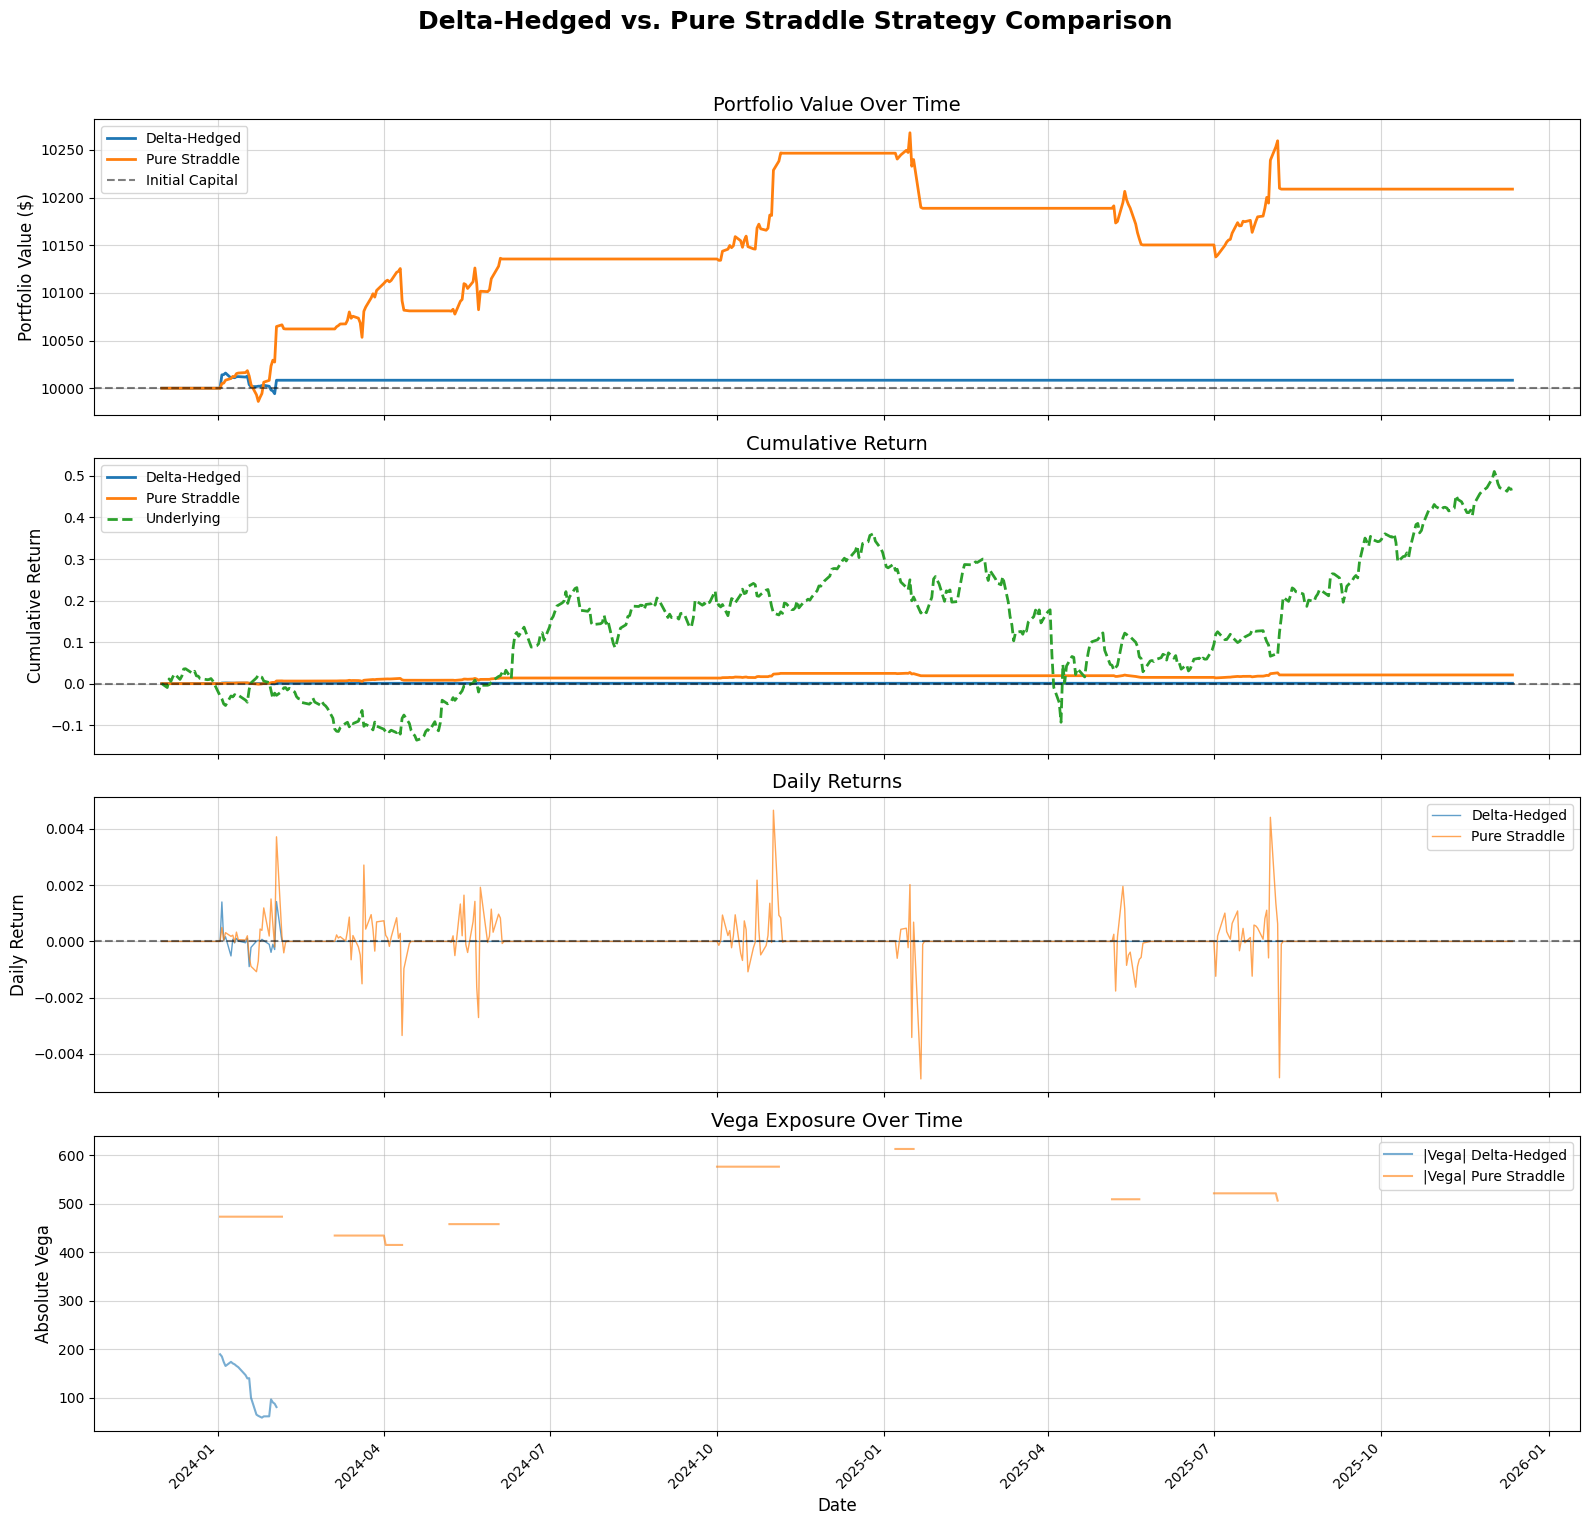


📊 Strategy Comparison Summary:
      Metric Delta-Hedged Pure Straddle
   Final NAV      $10,008       $10,209
Total Return        0.08%         2.09%
Sharpe Ratio         0.25          0.99
Max Drawdown        0.22%         1.27%


In [28]:
fig, axs = plt.subplots(4, 1, figsize=(16, 16), sharex=True)
fig.suptitle('Delta-Hedged vs. Pure Straddle Strategy Comparison', fontsize=18, fontweight='bold')

# 1. NAV
axs[0].plot(date_idx, nav_ddh_arr, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[0].plot(date_idx, nav_straddle_arr, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[0].axhline(10000, color='black', linestyle='--', alpha=0.5, label='Initial Capital')
axs[0].set_ylabel('Portfolio Value ($)', fontsize=12)
axs[0].set_title('Portfolio Value Over Time', fontsize=14)
axs[0].grid(True, alpha=0.5)
axs[0].legend()

# 2. Cumulative Return (with underlying)
axs[1].plot(date_idx, cum_ddh, label='Delta-Hedged', color='tab:blue', linewidth=2)
axs[1].plot(date_idx, cum_straddle, label='Pure Straddle', color='tab:orange', linewidth=2)
axs[1].plot(date_idx, cum_underlying, label='Underlying', color='tab:green', linewidth=2, linestyle='--')
axs[1].axhline(0, color='black', linestyle='--', alpha=0.5)
axs[1].set_ylabel('Cumulative Return', fontsize=12)
axs[1].set_title('Cumulative Return', fontsize=14)
axs[1].grid(True, alpha=0.5)
axs[1].legend()

# 3. Daily Returns (histogram inset optional)
axs[2].plot(date_idx, ret_ddh, label='Delta-Hedged', color='tab:blue', alpha=0.7, linewidth=1)
axs[2].plot(date_idx, ret_straddle, label='Pure Straddle', color='tab:orange', alpha=0.7, linewidth=1)
axs[2].axhline(0, color='black', linestyle='--', alpha=0.5)
axs[2].set_ylabel('Daily Return', fontsize=12)
axs[2].set_title('Daily Returns', fontsize=14)
axs[2].grid(True, alpha=0.5)
axs[2].legend()

# 4. Vega Exposure (risk comparison)
axs[3].plot(date_idx, np.abs(vega_ddh), label='|Vega| Delta-Hedged', color='tab:blue', alpha=0.6)
axs[3].plot(date_idx, np.abs(vega_straddle), label='|Vega| Pure Straddle', color='tab:orange', alpha=0.6)
axs[3].set_xlabel('Date', fontsize=12)
axs[3].set_ylabel('Absolute Vega', fontsize=12)
axs[3].set_title('Vega Exposure Over Time', fontsize=14)
axs[3].grid(True, alpha=0.5)
axs[3].legend()

# Format dates
for ax in axs:
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(axs[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

# ==========================
# Summary Table
# ==========================
summary_df = pd.DataFrame({
    'Metric': ['Final NAV', 'Total Return', 'Sharpe Ratio', 'Max Drawdown'],
    'Delta-Hedged': [
        f"${nav_ddh_arr[-1]:,.0f}",
        f"{tot_ddh:.2%}",
        f"{sharpe_ddh:.2f}",
        f"{dd_ddh:.2%}"
    ],
    'Pure Straddle': [
        f"${nav_straddle_arr[-1]:,.0f}",
        f"{tot_straddle:.2%}",
        f"{sharpe_straddle:.2f}",
        f"{dd_straddle:.2%}"
    ]
})

print("\n📊 Strategy Comparison Summary:")
print(summary_df.to_string(index=False))